## Predicting robust voxels using ILC regularized objective over a set of subjects on a stop signal task

You might need to upload the files into the collab directory. The files used in this script are located inside the example dataset folder : 
 

*   sub-01/func/sub-01_task-stopsignal_run-01_bold.nii.gz
*   sub-02/func/sub-02_task-stopsignal_run-01_bold.nii.gz


### My understanding of the problem and steps we need to take:

#### **The traditional approach**

The traditional approach to handling fMRI data is to regress the signal of each voxel with the convolution of their step response with the Haemodynamic response (HRF). Let's say we got an experiment in which the subject's repsonse could be a choice among $k$ categories (for instance north, south, east, and west). Each category has a BOLD impulse response or HRF. When measuring the subject's response, we get a sequence of step functions for ***each voxel*** (something like the figure below, ***but in our case is it spike/sec? Or just binary valued steps?***). To get the BOLD response, we would then convolve this function with the HRF of all categories (As the system is LTI, we're convolving the input with the impulse response to get the output, in some sense it accounts for the time dependence of the brain response to earlier activities). ***Is y in our data like the figure on the right or the left?*** 

  Traditionally they construct a **Design Matrix $X^{T\times |categories|}$**, where $T$ refers to the timesteps. $X_{ij}$ determines the effect of category $j$ on the signal of a specific voxel at time $i$ (***I'm not sure how exactly it's quantified.***). Then they solve a GLM for each voxel $y^{(i)}=X.\beta^{(i)}$

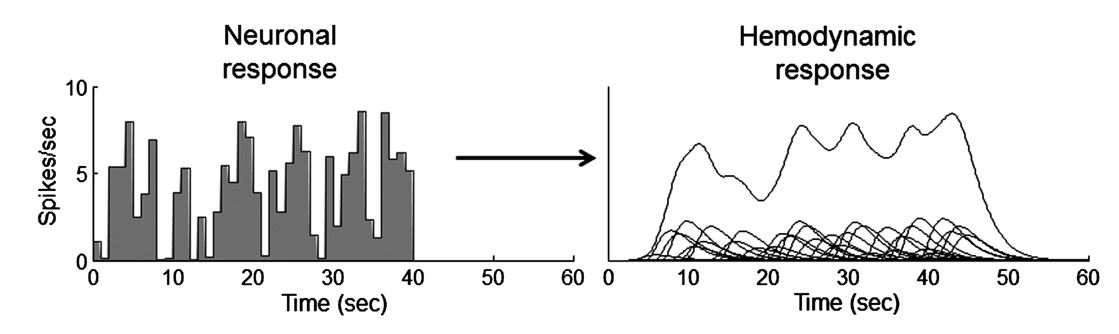

Figure adapted from Guillame Flandin's Slides (UCL)

#### **Our approach**
In my understanding our target variable is whether an action is taken or not (perhaphs again among a set of $k$ categorical choices). Then the whole signal $y$ over time would be something like the figure on the left, *where this time the vertical axis is not spikes/sec, rather they're just binary values*. ***So would we get any smoothing/convolution with HRF? Does it make any sense to convolve them with such a signal for $y$?*** 

Now suppose we've got a well-defined signal $y$ over time. **So something like the figure above on the right would be the target variable we're trying to predict using an ILC/IRM regularized neural network**). Then our problem would be to choose robust *voxel* predictors, whereas in the traditional approach predictors were associated with each *voxel* (recall $\beta$'s). Several questions:


1.   Is there any work that treats voxels like this? It seems that there should be, and if that's the case, then we can see how they chose $y$ and those would be our baselines to check our ILC/IRM regularized performance.
2.   What would be the architecture of our network? One simple suggestion would be the figure below with only a single hidden layer. The input layer is the flattened fmri image. The hidden layer has exactly the same number of nodes as it represents the number of voxels, and we're trying to find the robust ones. One could argue why not deeper? Shall we deepen it after getting a probably satisfactory initial result?
3. How about the fully connected architecture? Is it plausible? After all, let's say there are 100000 voxels, is it really necessary that we introduce an effect from the 100000th voxel on the first one by a fully connected architecture?

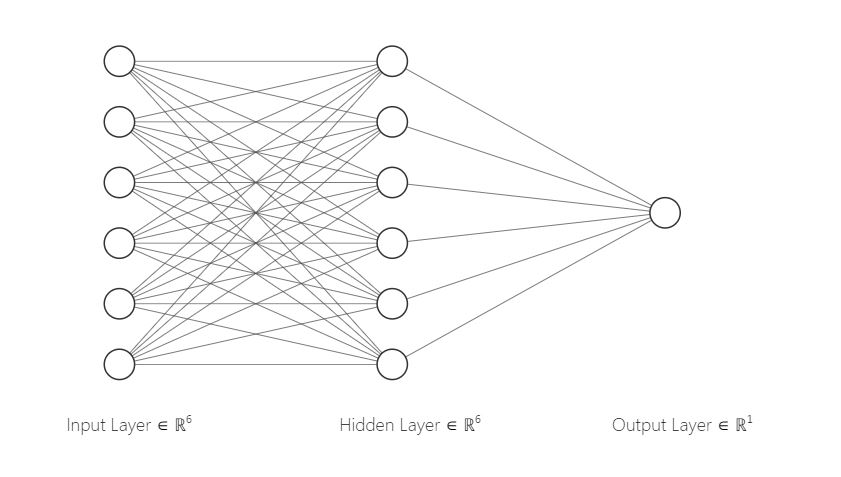

Now suppose we've decided the network architecture. Next step would be to define a loss function. This depends on the definition of $y$. If a signal like the figure above is chosen, then $l$-2 norm reconstruction error would be the suitable choice. If it's a binary value, then we'll need to use cross-entropy loss.

When we've settled on all of the required design choices, these would be the tasks:

Since the poster presentation is on Dec 15th, we need to finish the project by Dec 12th or 13th, to leave enough room for the poster preparation (and of course other projects/hw we may have :) ).

1.   Flattening the fMRI data
2.   Defining the network class in torch
3. Running SGD on the **Elastic Net** objective to get the initial results. Testing the obtained network OOD.
4. Using the AND-masked gradients like how it's done in GB's code, or do so by JAX
5. Testing the newly obtained (hopefully robust) network OOD.
6. If it had generalized well ood, then highlight the robust voxel predictors in 2D images to be included in the report.



In [1]:
# !pip install nilearn

The datasets we will be using will be a set of nifti files, so we need a library which can read and manipulate those files into matrices. Nilearn is standard for python, and it has the tools we need to handle this type of data (see example dataset in README). We can build a list of 4D files, then read them one-by-one and extract the slices of interest. 


In [3]:
import numpy as np 
import os
from nilearn.image import index_img, smooth_img

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils

import pickle 

In [4]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# !unzip '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/data.zip' -d '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/'

### Class definitions

In [5]:
# In case we wanted to do experiments with ILC inter subjects.
# This class is also good when we want to deal with different runs from the same
# subject.
class fmriDatasetAllSubjects(Dataset):
    """fMRI dataset when all subjects data is mixed."""

    def __init__(self, root_dir, files_paths, list_of_partitions, list_of_labels, format, transform=None):
        # event_file could be added when real data is available.
        # add this argument later: tsv_file
        """
        Args:
            files_paths (string): Path to the (fmri) file (nifti or npy).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample, i.e. flattening and subsampling.
        """
        self.root_dir = root_dir

        if format is 'nifti':
            self.number_of_subjects = len(files_paths)
            self.labels = np.concatenate([list_of_labels[i] for i in range(self.number_of_subjects)], axis=0)

            # list of NiftiImage objects for different subjects, i.e., if there are "two" 
            # subjects, then X contains "two" 4-D images of shape (x_dim,y_dim,z_dim,time)
            X = []

            # list of events
            Y = []

            # This loop goes over the nifti images of the subjects
            for index, image_path in enumerate(files_paths):
                # load image and remove nan and inf values.
                # applying smooth_img to an image with fwhm=None simply cleans up
                # non-finite values but otherwise doesn't modify the image.
                self.path = os.path.join(self.root_dir, image_path)
                image = smooth_img(self.path, fwhm=None)
                X.append(image)

            self.subject_frames = np.concatenate([X[i].get_fdata()[:,:,:,list_of_partitions[i]] for i in range(self.number_of_subjects)], axis=3)

        else:
            self.labels = list_of_labels

            self.path = os.path.join(self.root_dir, files_paths)
        
            images = np.load(self.path, encoding='bytes')
            images = images[list_of_partitions,:,:,:]
            images = np.reshape(images, (images.shape[1],images.shape[2],images.shape[3],images.shape[0]))

            
            self.subject_frames = images

        self.transform = transform

    def __len__(self):
        return (self.subject_frames).shape[3]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.subject_frames[:,:,:,idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, self.labels[idx]

# In case we wanted to do experiments with ILC intra subjects
class fmriDatasetSubject(Dataset):
    """fMRI dataset for each subject."""

    def __init__(self, root_dir, file_path, list_IDs, labels, format, transform=None):
        # event_file could be added when real data is available.
        # add this argument later: tsv_file
        """
        Args:
            file_path (string): Path to the (fmri) file (nifti or npy).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample, i.e. flattening and subsampling.
        """
        
        self.root_dir = root_dir
        self.file_path = file_path
        self.labels = labels
        self.path = os.path.join(self.root_dir, self.file_path)
        
        if format is 'nifti':
            self.subject_frames = smooth_img(self.path, fwhm=None).get_fdata()
            self.subject_frames = self.subject_frames[:,:,:,list_IDs]

        else:

            images = np.load(self.path, encoding='bytes')
            images = images[list_IDs,:,:,:]
            images = np.reshape(images, (images.shape[1],images.shape[2],images.shape[3],images.shape[0]))
            self.subject_frames = images


        self.transform = transform

    def __len__(self):
        return (self.subject_frames).shape[3]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.subject_frames[:,:,:,idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, self.labels[idx]

class Flatten(object):
    """flatten the 3D image of a timestep.

    Args:
    """

    def __init__(self):
        pass

    def __call__(self, sample):

        dim_x = sample.shape[0]
        dim_y = sample.shape[1]
        dim_z = sample.shape[2]

        sample = sample.reshape(dim_x*dim_y,dim_z)
        sample = sample.reshape(sample.shape[0]*dim_z)
        return sample

class Subsample(object):
    """subsample the 3D image of a timestep.

    Args:
    """

    def __init__(self, subsample_rate_x,subsample_rate_y,subsample_rate_z):
        self.rate_x = subsample_rate_x
        self.rate_y = subsample_rate_y
        self.rate_z = subsample_rate_z

    def __call__(self, sample):

        dim_x = sample.shape[0]
        dim_y = sample.shape[1]
        dim_z = sample.shape[2]

        indexes_x = range(0,dim_x,self.rate_x)
        indexes_y = range(0,dim_y,self.rate_y)
        indexes_z = range(0,dim_z,self.rate_z)

        sample = sample[indexes_x,:,:]
        sample = sample[:,indexes_y,:]
        sample = sample[:,:,indexes_z]

        return sample


### Instantiating the Dataset classes from nifti files

In [6]:
root_dir = './data'
# nifti_file = 'sub-0' + str(subject) + '_task-stopsignal_run-01_bold.nii.gz'

number_of_subjects = 3
subsampler = Subsample(2,2,2)
flat = Flatten()

composed_transform = transforms.Compose([subsampler,flat])

In [7]:
data_format = 'npy' # 'npy' or 'nifti'

number_of_subjects = 2


subjects_individual_train_datasets = []
subjects_individual_test_datasets = []

files_paths = []

# partition = {'train':list(range(0,91)), 'test':list(range(91,182))}
partition = {'train':list(range(0,123)), 'test':list(range(123,246))}


# For having flexibility in defining various train and test partitions when using
# the mixed dataset of all subjects, we may use the list of partitions and labels
# as below

partitions_mixed = dict.fromkeys(['train','test'])
partitions_mixed['train'],partitions_mixed['test'] = [],[]

labels_mixed = dict.fromkeys(['train','test'])
labels_mixed['train'],labels_mixed['test'] = [],[]

for subject in range(number_of_subjects):
    # one might change the partitions for each subject.
    partitions_mixed['train'].append(list(range(0,91)))
    partitions_mixed['test'].append(list(range(91,182)))
    labels_mixed['train'].append((np.zeros(91)).astype(int))
    labels_mixed['test'].append((np.zeros(91)).astype(int))

if data_format is 'nifti':

    labels = {'train':(np.zeros(91)).astype(int), 'test':(np.zeros(91)).astype(int)}

    for subject in range(1,number_of_subjects+1):
        path = 'sub-0' + str(subject) + '_task-stopsignal_run-01_bold.nii.gz'
        files_paths.append(path)

    subjects_individual_train_datasets.append(fmriDatasetSubject(root_dir, path, partition['train'], labels['train'], data_format, composed_transform))
    subjects_individual_test_datasets.append(fmriDatasetSubject(root_dir, path, partition['test'], labels['test'], data_format, composed_transform))

    mixed_dataset_train = fmriDatasetAllSubjects(root_dir, files_paths, partitions_mixed['train'], labels_mixed['train'], data_format, composed_transform)
    mixed_dataset_test = fmriDatasetAllSubjects(root_dir, files_paths,  partitions_mixed['test'], labels_mixed['test'], data_format, composed_transform)

else:

    subjects_event_paths = './data/y.npy'
    events = np.load(subjects_event_paths, encoding='bytes')
    events[np.where(events == -1)] = 1
    
    labels = dict.fromkeys(['train','test'])
    labels['train'],labels['test'] = events[partition['train']],events[partition['test']]

    files_paths = 'X.npy'

    mixed_dataset_train = fmriDatasetAllSubjects(root_dir, files_paths, partition['train'], labels['train'], data_format, composed_transform)
    mixed_dataset_test = fmriDatasetAllSubjects(root_dir, files_paths,  partition['test'], labels['test'], data_format, composed_transform)

# print(labels)
print(getattr(mixed_dataset_train, 'subject_frames').shape)
print(mixed_dataset_train[57][0].shape)

(63, 74, 49, 123)
(29600,)


In [8]:
# print(getattr(b,'subject_frames').shape)
print(mixed_dataset_train,mixed_dataset_test)
print(getattr(mixed_dataset_train,'subject_frames').shape)
print(getattr(mixed_dataset_test,'subject_frames').shape)
print(mixed_dataset_train[0][0].shape[0])

<__main__.fmriDatasetAllSubjects object at 0x10f1b2700> <__main__.fmriDatasetAllSubjects object at 0x13035d4f0>
(63, 74, 49, 123)
(63, 74, 49, 123)
29600


### Loading and Storing the generated Datasets

In [9]:
# How to access these custom datasets
# print(subjects_individual_datasets[0][2])
# print(mixed_dataset[4])

def storeData(object, file_name, root_dir):
    with open(root_dir+file_name, 'wb') as f:
        pickle.dump(object, f)					 
        f.close() 

def loadData(file_name, root_dir): 
    with open(root_dir+file_name, 'rb') as f:
        db = pickle.load(f) 
        f.close()
        return db


# storeData(subjects_individual_train_datasets, 'subjects_individual_train_datasets', root_dir)
# storeData(subjects_individual_test_datasets, 'subjects_individual_test_datasets', root_dir)

# storeData(mixed_dataset_train, 'mixed_dataset_train', root_dir)
# storeData(mixed_dataset_test, 'mixed_dataset_test', root_dir)


# mixed_dataset_train = loadData('mixed_dataset_train', root_dir)
# mixed_dataset_test = loadData('mixed_dataset_test', root_dir)
# print((getattr(mixed_dataset_train,'subject_frames').shape[3]))
# print(getattr(mixed_dataset_test,'subject_frames').shape)

### Calculating the weights of the labels. (They're unbalanced and need to be taken care of in the cross entropy loss)


In [10]:

# We weight the training loss by the weight of labels in the training set.
Y = getattr(mixed_dataset_train,'labels')
weights = [len(np.where(Y == 0)[0]), len(np.where(Y == 1)[0])]/np.max([len(np.where(Y == 0)[0]), len(np.where(Y == 1)[0])])
print(weights)

[1.         0.32258065]


### Model Definition

In [11]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


fc_dim = mixed_dataset_train[0][0].shape[0]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(np.int(fc_dim), np.int(fc_dim))
        self.fc2 = nn.Linear(np.int(fc_dim), 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(x, dim = 0)

        return x

model = Net()

False


### Training with pure and simple SGD

In [12]:
# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 6}

max_epochs = 3

# Since the labels are probably unbalanced, cross entropy loss should get the weight parameter
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight = torch.from_numpy(weights).float())

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)
criterion.to(device)

# Generators
training_set = mixed_dataset_train
training_generator = DataLoader(training_set, batch_size=32,shuffle=True, num_workers=0, drop_last=False)

validation_set = mixed_dataset_test
validation_generator = DataLoader(validation_set, batch_size=32, shuffle=True, num_workers=0, drop_last=False)

# Loop over epochs
for epoch in range(max_epochs):
    running_loss = 0
    # Training
    batch_number = 0
    for input_batch, input_labels in training_generator:
        batch_number += 1
        # Transfer to GPU
        input_batch, input_labels = input_batch.to(device), input_labels.to(device)
        # Model computations
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_batch.float())

        loss = criterion(outputs, input_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        # running_loss += loss.item()
        # if i % 10 == 0:    # print every 10 samples
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0

    # Validation
    with torch.set_grad_enabled(False):
        total_loss = 0
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            outputs = model(local_batch.float())
            loss = criterion(outputs, local_labels)
            total_loss += loss
            
        print(total_loss)

print('Finished Training')

In [ ]:
torch.save(model.state_dict(), './model')
# model.load_state_dict(torch.load(PATH))

### Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

test_gen = torch.utils.data.DataLoader(mixed_dataset_test, batch_size=mixed_dataset_test.__len__(), shuffle=False)
for test_data, test_labels in test_gen:
    pass
    # print(test_data.shape, test_labels.shape)

# print(test_data.shape, test_labels.shape)

def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs==labels)/float(len(labels))

def evaluate(model, validation_data, validation_labels):

    validation_data = validation_data.to(device)

    out = model(validation_data.float())
    # print(out.shape)
    outputs = np.argmax(out.cpu().detach().numpy(), axis=1)
    # print(outputs)
    acc = accuracy(out.cpu().detach().numpy(), validation_labels.cpu().detach().numpy())
    print('Accuracy: ', acc)

    # As mentioned before, data is unbalanced, hence, the accuracy itself is not 
    # enough for evaluating the performance of the model.
    # print(outputs,local_labels.cpu().detach().numpy())
    cm = confusion_matrix(outputs.transpose(), validation_labels.detach().cpu().numpy().transpose())
    sns.set_theme()
    plt.figure()
    ax = sns.heatmap(cm)
    print('\nConfusion Matrix: ', cm)
    precision,recall,fscore,_ = precision_recall_fscore_support(validation_labels.cpu(), outputs)
    print('\nPrecision: ',precision,'\nRecall: ', recall,'\nF-score: ', fscore)

evaluate(model, test_data, test_labels)


### Playground for incorporating ILC

In [1]:
def add_l1_grads(l1_coef, param_groups):
    for group in param_groups:
        for p in group['params']:
            assert p.grad is not None, 'We have not decided yet what to do in this case'
            grad = p.grad.data
            grad.add_(l1_coef, torch.sign(p.data))

def add_l2_grads(l2_coef, param_groups):
    for group in param_groups:
        for p in group['params']:
            assert p.grad is not None, 'We have not decided yet what to do in this case'
            grad = p.grad.data
            grad.add_(2*l2_coef, p.data)

def get_grads(agreement_threshold, batch_size, loss_fn,
              n_agreement_envs, params, output,
              target,
              method,
              scale_grad_inverse_sparsity,
              ):
    """
    Use the and mask or the geometric mean to put gradients together.
    Modifies gradients wrt params in place (inside param.grad).
    Returns mean loss and masks for diagnostics.
    Args:
        agreement_threshold: a float between 0 and 1 (tau in the paper).
            If 1 -> requires complete sign agreement across all environments (everything else gets masked out),
             if 0 it requires no agreement, and it becomes essentially standard sgd if method == 'and_mask'. Values
             in between are fractional ratios of agreement.
        batch_size: The original batch size per environment. Needed to perform reshaping, so that grads can be computed
            independently per each environment.
        loss_fn: the loss function
        n_agreement_envs: the number of environments that were stacked in the inputs. Needed to perform reshaping.
        params: the model parameters
        output: the output of the model, where inputs were *all examples from all envs stacked in a big batch*. This is
            done to at least compute the forward pass somewhat efficiently.
        method: 'and_mask' or 'geom_mean'.
        scale_grad_inverse_sparsity: If True, rescale the magnitude of the gradient components that survived the mask,
            layer-wise, to compensate for the reduce overall magnitude after masking and/or geometric mean.
    Returns:
        mean_loss: mean loss across environments
        masks: a list of the binary masks (every element corresponds to one layer) applied to the gradient.
    """

    param_gradients = [[] for _ in params]
    outputs = output.view(n_agreement_envs, batch_size, -1)
    targets = target.view(n_agreement_envs, batch_size, -1)

    outputs = outputs.squeeze(-1)
    targets = targets.squeeze(-1)

    total_loss = 0.
    for env_outputs, env_targets in zip(outputs, targets):
        env_loss = loss_fn(env_outputs, env_targets)
        total_loss += env_loss
        env_grads = torch.autograd.grad(env_loss, params,
                                           retain_graph=True)
        for grads, env_grad in zip(param_gradients, env_grads):
            grads.append(env_grad)
    mean_loss = total_loss / n_agreement_envs
    assert len(param_gradients) == len(params)
    assert len(param_gradients[0]) == n_agreement_envs

    masks = []
    avg_grads = []
    weights = []
    for param, grads in zip(params, param_gradients):
        assert len(grads) == n_agreement_envs
        grads = torch.stack(grads, dim=0)
        assert grads.shape == (n_agreement_envs,) + param.shape
        grad_signs = torch.sign(grads)
        mask = torch.mean(grad_signs, dim=0).abs() >= agreement_threshold
        mask = mask.to(torch.float32)
        assert mask.numel() == param.numel()
        avg_grad = torch.mean(grads, dim=0)
        assert mask.shape == avg_grad.shape

        if method == 'and_mask':
            mask_t = (mask.sum() / mask.numel())
            param.grad = mask * avg_grad
            if scale_grad_inverse_sparsity:
                param.grad *= (1. / (1e-10 + mask_t))
        elif method == 'geom_mean':
            prod_grad = torch.sign(avg_grad) * torch.exp(torch.sum(torch.log(torch.abs(grads) + 1e-10), dim=0) / n_agreement_envs)
            mask_t = (mask.sum() / mask.numel())
            param.grad = mask * prod_grad
            if scale_grad_inverse_sparsity:
                param.grad *= (1. / (1e-10 + mask_t))
        else:
            raise ValueError()

        weights.append(param.data)
        avg_grads.append(avg_grad)
        masks.append(mask)

    return mean_loss, masks

In [12]:
# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 6}

config = {'agreement_threshold': 0.2, 'scale_grad_inverse_sparsity': 1, 'method': 'and_mask'}

max_epochs = 3

l1_coef = l2_coef = 0.2

# Since the labels are probably unbalanced, cross entropy loss should get the weight parameter
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight = torch.from_numpy(weights).float())

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)
criterion.to(device)

# Generators
training_set = mixed_dataset_train
training_generator = DataLoader(training_set, batch_size=32,shuffle=True, num_workers=0, drop_last=False)

validation_set = mixed_dataset_test
validation_generator = DataLoader(validation_set, batch_size=32, shuffle=True, num_workers=0, drop_last=False)

# Loop over epochs
for epoch in range(max_epochs):
    running_loss = 0
    print(epoch)
    # Training
    batch_number = 0
    for input_batch, input_labels in training_generator:
        batch_number += 1
        # Transfer to GPU
        input_batch, input_labels = input_batch.to(device), input_labels.to(device)
        # Model computations
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_batch.float())

        if config['agreement_threshold'] > 0.0:
            # The "batch_size" in this function refers to the batch size per env
            # Since we treat every example as one env, we should set the parameter
            # n_agreement_envs equal to batch size
            mean_loss, masks = get_grads(
                agreement_threshold=config['agreement_threshold'],
                batch_size=1,
                loss_fn=criterion,
                n_agreement_envs=len(input_labels),
                params=optimizer.param_groups[0]['params'],
                output=outputs,
                target=input_labels,
                method=config['method'],
                scale_grad_inverse_sparsity=config['scale_grad_inverse_sparsity'],
            )

            if l1_coef > 0.0:
                add_l1_grads(l1_coef, optimizer.param_groups)

            if l2_coef > 0.0:
                add_l2_grads(l2_coef, optimizer.param_groups)

        else:
            mean_loss = criterion(outputs, input_labels)
            mean_loss.backward()
        
        optimizer.step()

        # print statistics
        # running_loss += loss.item()
        # if i % 10 == 0:    # print every 10 samples
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0

    # Validation
    with torch.set_grad_enabled(False):
        total_loss = 0
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            outputs = model(local_batch.float())
            loss = criterion(outputs, local_labels)
            total_loss += loss
            
        print(total_loss)

print('Finished Training')

### Examples for working with the fmri data

In [ ]:
print(X[0])
numpy_4d_img = X[0].dataobj
numpy_4d_img.shape 
print(numpy_4d_img)

In [ ]:
slice_50 = index_img(X[0], 50) # grab slice number 50 into a 
slice_50_60 = index_img(X[0], slice(50, 60)) # grab slice number 50 to 60 

slice_50.shape, slice_50_60.shape

((64, 64, 30), (64, 64, 30, 10))

In [ ]:
a = index_img(X[0], 181)
print(a.header)

In [ ]:
from nilearn import plotting
from nilearn import image
data = slice_50.get_fdata()
# plotting.plot_stat_map(slice_50)

In [ ]:
for img in image.iter_img(slice_50_60):
    # img is now an in-memory 3D img
    # print(slice_50_60)
    plotting.plot_stat_map(img, threshold=0, display_mode="z", cut_coords=1,
                           colorbar=False)